In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

In [4]:
SOS_token = 0
EOS_token = 1
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: SOS_token, 1: EOS_token}  # Numbers instead of strings
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split():
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Normalization function (removes extra spaces)
def normalizeString(s):
    return s.strip()

def readLangs(file_path, lang1, lang2, reverse=False):
    """Reads tab-separated English-Nepali pairs from a file."""
    print("Reading lines...")

    # Read the file and split into lines
    with open(file_path, encoding='utf-8') as f:
        lines = f.read().strip().split("\n")

    # Split each line into an English-Nepali pair
    pairs = [list(map(normalizeString, line.split("\t"))) for line in lines if "\t" in line]

    # Reverse pairs if needed
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

MAX_LENGTH = 10

def filterPair(p):
    """Filters sentence pairs based on max length and empty sentences."""
    return len(p[0].split()) < MAX_LENGTH and len(p[1].split()) < MAX_LENGTH and p[0] != '' and p[1] != ''


def filterPairs(pairs):
    """Applies filtering to all pairs."""
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(file_path, lang1, lang2, reverse=False):
    """Loads, cleans, and processes data."""
    input_lang, output_lang, pairs = readLangs(file_path, lang1, lang2, reverse)
    print(f"Read {len(pairs)} sentence pairs")

    pairs = filterPairs(pairs)
    print(f"Trimmed to {len(pairs)} sentence pairs")

    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    print("Counted words:")
    print(f"{input_lang.name}: {input_lang.n_words}")
    print(f"{output_lang.name}: {output_lang.n_words}")

    return input_lang, output_lang, pairs

# File path to your dataset
file_path = "data/eng-nep.txt"

# Process data
input_lang, output_lang, pairs = prepareData(file_path, "eng", "nep", True)

print(random.choice(pairs))

Reading lines...
Read 104317 sentence pairs
Trimmed to 104142 sentence pairs
Counting words...
Counted words:
nep: 18250
eng: 10316
['केहि खानुहोस्', 'eat something']


In [5]:

for idx, word in input_lang.index2word.items():
    print(f"{idx}: {word}")

for idx, word in output_lang.index2word.items():
    print(f"{idx}: {word}")

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights
    

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData(file_path, "eng", "nep", True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

0: 0
1: 1
2: जानुहोस्
3: दौड!
4: वाह!
5: आगो!
6: मद्दत
7: गर्नुहोस्!
8: जम्प
9: रोक्नुहोस्!
10: पर्ख!
11: म
12: देख्छु
13: प्रयास
14: गर्छु
15: मैले
16: जितें!
17: अरे
18: होइन!
19: आक्रमण!
20: जय
21: होस्!
22: उठ
23: बुझ्यो!
24: पाउनुभयो?
25: भित्र
26: हाप
27: मलाई
28: अँगालो
29: खसे
30: थाहा
31: छ
32: छोडें
33: हारे
34: im
35: ठीक
36: छु
37: सुन्नुहोस्
38: कुनै
39: तरिका
40: छैन!
41: साँच्चै?
42: धन्यवाद
43: हामी
44: गर्छौं
45: हामीले
46: जित्यौं
47: टमलाई
48: सोध्नुहोस्
49: गजब
50: !
51: शान्त
52: हुनुहोस्
53: निष्पक्ष
54: दयालु
55: राम्रो
56: यसलाई
57: पिट्नुहोस्
58: कल
59: गर्नुहोस्
60: हामीलाई
61: आउ
62: आउनुहोस्!
63: आउनुहोस्
64: छोड्नुहोस्!
65: बाहिर
66: जानुहोस्!
67: निस्कनुहोस्
68: टाढा
69: ढिलो
70: अलविदा!
71: पर्खनुहोस्!
72: पर्खनुहोस्
73: उसले
74: छोड्यो
75: ऊ
76: दौडन्छ
77: समात्नुहोस्!
78: होल्ड
79: सहमत
80: गरें
81: जान्छु
82: मोटो
83: फिट
84: हिट
85: छु!
86: बिरामी
87: दुखी
88: लजालु
89: भिजेको
90: यो
91: हुँ!
92: हामीसँग
93: सामेल
94: राख्नुहोस्
95: चुम्बन
96: पनि
97:

In [6]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
import matplotlib as plt
%matplotlib inline
def showPlot(losses, accuracies=None):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Loss', color='blue')
    plt.title('Loss Over Time')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if accuracies:
        # Plot accuracy if available
        plt.subplot(1, 2, 2)
        plt.plot(accuracies, label='Accuracy', color='green')
        plt.title('Accuracy Over Time')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.legend()

    plt.tight_layout()
    plt.show()

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
          print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        # Print progress every 'print_every' epochs
        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            elapsed_time = timeSince(start, epoch / n_epochs)
            print(f"Epoch {epoch}/{n_epochs} ({elapsed_time}) - "
                  f"Average Loss: {print_loss_avg:.4f}")

        # Plot progress every 'plot_every' epochs
        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    # Show the loss plot after training is complete
    showPlot(plot_losses)

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn


def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('Input>', pair[0])
        print('TranslationFromDataset=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('TranslationFromModel<', output_sentence)
        print('')
        




In [7]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

Reading lines...
Read 104317 sentence pairs
Trimmed to 104142 sentence pairs
Counting words...
Counted words:
nep: 18250
eng: 10316


In [ ]:

epochnumber=30
train(train_dataloader, encoder, decoder, epochnumber, print_every=1, plot_every=epochnumber)
import matplotlib.pyplot as plt

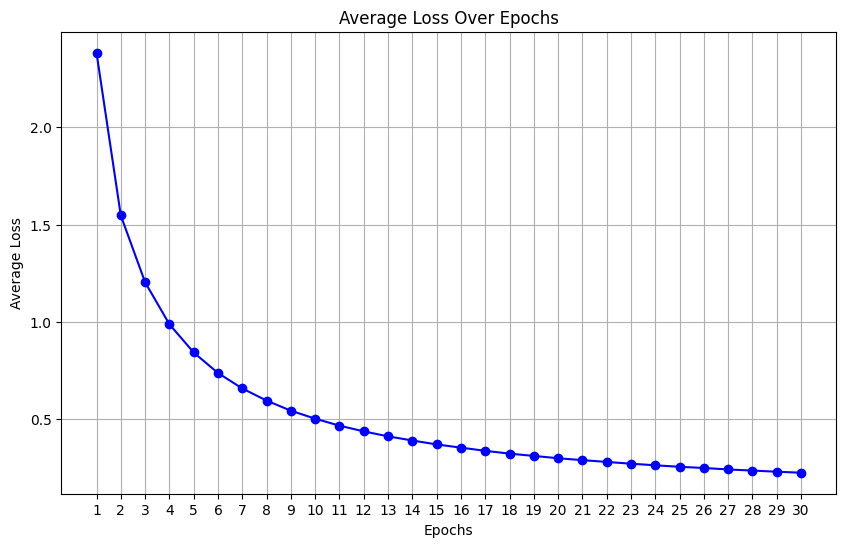

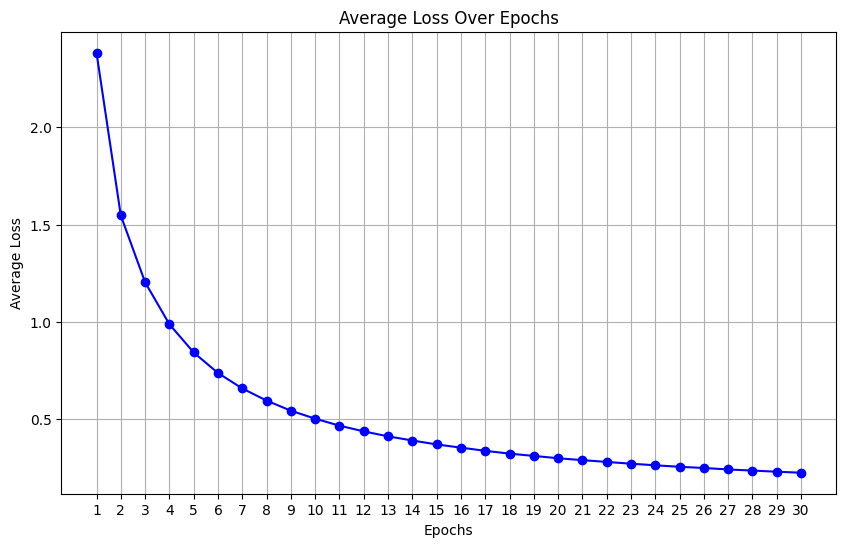

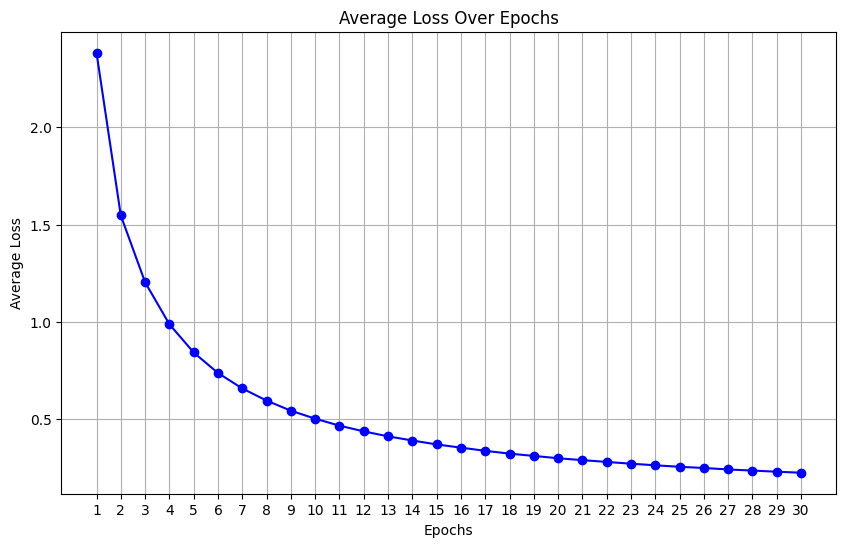

In [17]:
# Data from the training log
%matplotlib inline
epochs = list(range(1, 31))
average_loss = [
    2.3835, 1.5474, 1.2043, 0.9886, 0.8436, 0.7381, 0.6588, 0.5964,
    0.5445, 0.5036, 0.4676, 0.4383, 0.4128, 0.3914, 0.3713, 0.3547,
    0.3385, 0.3239, 0.3123, 0.3003, 0.2905, 0.2814, 0.2723, 0.2640,
    0.2564, 0.2502, 0.2427, 0.2369, 0.2311, 0.2259
]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, average_loss, marker='o', linestyle='-', color='b')
plt.title('Average Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.xticks(epochs)  # Show all epoch numbers on the x-axis
plt.grid()
plt.show()

In [8]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

Input> यदि मसँग उसको निमन्त्रणा स्वीकार गर्ने समय थियो भने
TranslationFromDataset= if i had time i d accept his invitation
TranslationFromModel< if i had time i d accept his invitation <EOS>

Input> म तिमीलाई आफ्नो ठाउँ पाउन चाहन्छु
TranslationFromDataset= i want you to get your own place
TranslationFromModel< i want you to get your own place <EOS>

Input> म तयार थिएँ
TranslationFromDataset= i was ready
TranslationFromModel< i was ready with one of ready <EOS>

Input> एक तीन र पाँच बिजोर संख्याहरू हुन्
TranslationFromDataset= one three and five are odd numbers
TranslationFromModel< three feet and she are five and pushed ! <EOS>

Input> तिमीलाई थाहा छ उनी कहाँ छिन् ?
TranslationFromDataset= do you know where she is ?
TranslationFromModel< do you know where she is ? <EOS>

Input> तपाईंले आफ्नो छुट्टीमा के गर्नुभयो?
TranslationFromDataset= what did you do on your vacation ?
TranslationFromModel< what did you do on your vacation ? <EOS>

Input> तिमी पातलो छौ
TranslationFromDataset= you re 

In [8]:
def talk(input_sentence):
    with torch.no_grad():
        input_sentence
        output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
        print('input =', input_sentence)
        print('output =', ' '.join(output_words))

In [17]:
sentence = "टम धेरै सुन्दर छ"
print(talk(sentence))

input = टम धेरै सुन्दर छ
output = tom is very pretty handsome <EOS>
None


In [10]:
# Load the checkpoint
device = torch.device("cpu")  
checkpoint = torch.load('PTnep2engV2.pt', map_location=device)

encoder = checkpoint['encoder_class'](checkpoint['input_lang_n_words'], checkpoint['hidden_size']).to(device)
decoder = checkpoint['decoder_class'](checkpoint['hidden_size'], checkpoint['output_lang_n_words']).to(device)
attention = checkpoint['attention_class'](checkpoint['hidden_size'])

# Load the state dictionaries
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])

print("Model loaded successfully!")

Model loaded successfully!


In [89]:
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
    'attention_state_dict': decoder.attention.state_dict(),
    'input_lang_n_words': input_lang.n_words,
    'output_lang_n_words': output_lang.n_words,
    'hidden_size': hidden_size,
    'encoder_class': EncoderRNN,
    'decoder_class': AttnDecoderRNN,
    'attention_class': BahdanauAttention
}, 'PTnep2engV2.pt')

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

